In [ ]:
from main import *

# toy example

train_sub = [1]
sigma = 1000
train_x0, train_y0 = make_train_dataset(train_sub, 0)
score_model0 = train_scorenet(train_x0, train_y0, sigma)

Score model Average Loss: 2359.868490, lr : 0.01:   2%|███▌                                                                                                                                                             | 67/3000 [01:51<1:21:39,  1.67s/it]

In [6]:
batch_size = 1
samples0 = sampling(score_model0, sample_batch_size=batch_size)

generated_signal0 = return_to_signal(samples0)

  0%|                                                                                                                                                                                                                               | 0/500 [00:00<?, ?it/s]/home/junyeobe/augment/train_scorenet.py:197: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device="cuda")
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 98.35it/s]


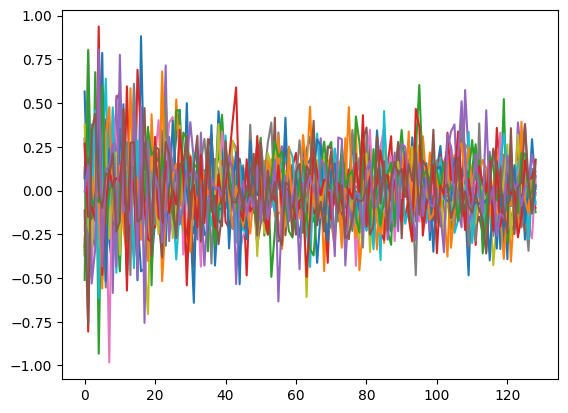

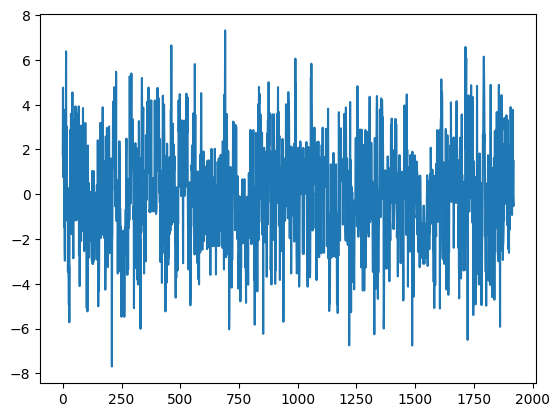

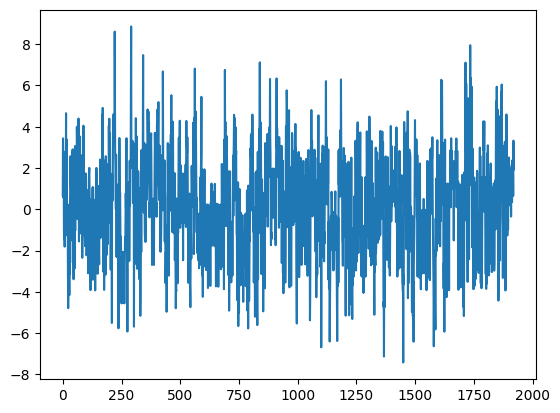

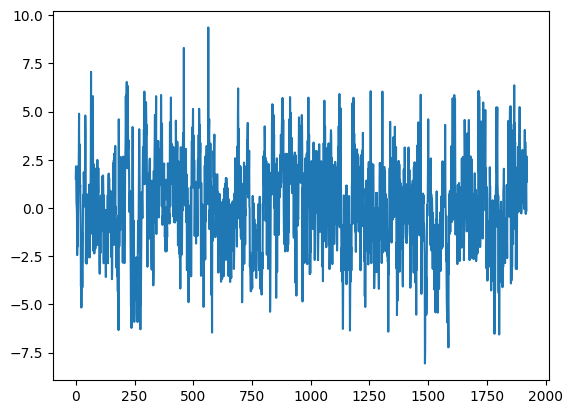

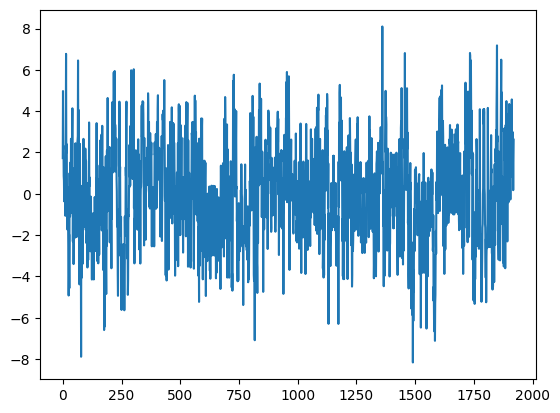

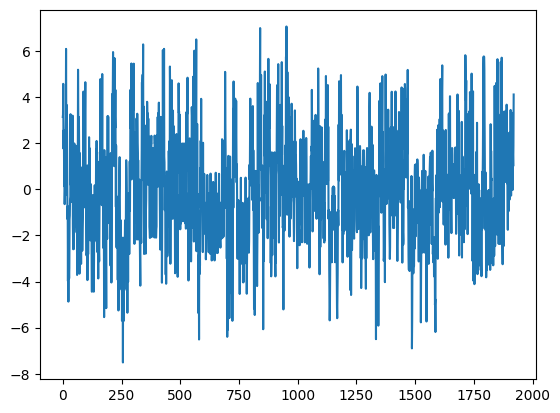

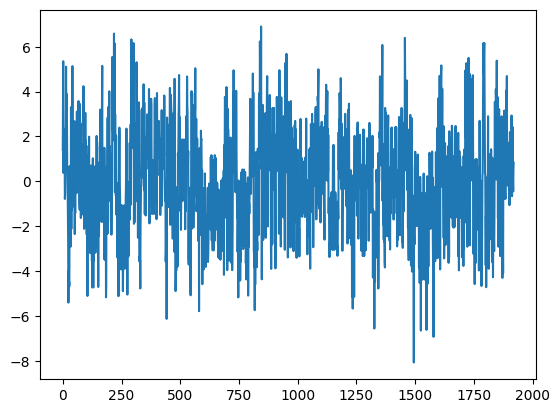

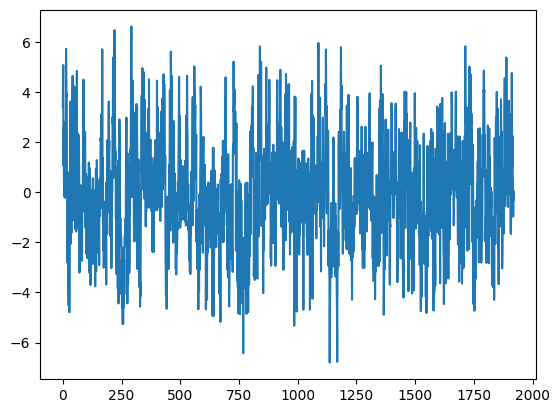

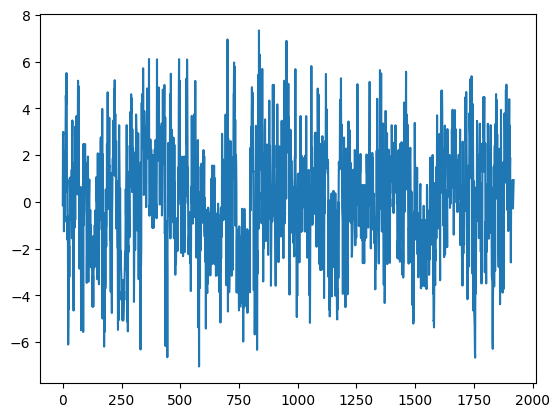

KeyboardInterrupt: 

In [7]:
import matplotlib.pyplot as plt


for sample in samples0:
    plt.plot(sample[0][0].cpu())
    plt.show()

for signal in generated_signal0[0][0]:
    plt.plot(signal)
    plt.show()


for x in train_x0:
    plt.plot(x[0])
    plt.show()
    
